# Summary Stats for MTurk Imposter Identification Task

**Author:** Jim Maddock

**Last Updated:** 10-20-20

**Description:** This notebook contains summary stats for the mturk imposter identification task described [here](https://docs.google.com/document/d/1_61OGy1BpsufPrD5FPFBcRQoS9sUPOQdzPxypuAhxuU/edit).  Stats include:
* **Dataset accuracy:** the number of correct answers over the number of tasks.
* **Cluster accuracy:** the same accuracy messure but for specific clusters.
* **Cluster size:** the relationship between the number of articles contained in a cluster and the accuracy.
* **IRR:** the relationship between inter-rater reliability (whether coders aggree with one another) and accuracy.

In [159]:
import pandas as pd
import numpy as np
import json
import os

import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use('ggplot')

pd.set_option("display.min_rows", 100)
pd.set_option("display.max_rows", 100)

In [160]:
#FILEPATH = '/Users/klogg/dev/wiki-ltt-mturk-validation/Batch_4216878_batch_results.csv'
BASEDIR = '/Users/klogg/research_data/wmf_knowledge_graph/mturk/v1/results/'

def loadResults(basedir):
    mturk_df = pd.DataFrame()
    file_list = [x for x in os.listdir(basedir) if x[0] != '.']
    print('loading files: {0}'.format(file_list))
    for filename in file_list:
        filepath = os.path.join(basedir,filename)
        mturk_df = mturk_df.append(pd.read_csv(filepath))
        
    return mturk_df

mturk_df = loadResults(BASEDIR)

#mturk_df = pd.read_csv(FILEPATH)

loading files: ['batch_4222837_b0.csv', 'batch_4224237_b2.csv', 'batch_4224240_b3.csv', 'batch_4222842_b1.csv', 'batch_4224241_b4.csv']


In [161]:
TASKS_PER_JOB = 10
ARTICLES_PER_TASK = 5

chunk = []

for i, job_row in mturk_df.iterrows():
    answer_dict = json.loads(job_row['Answer.taskAnswers'])[0]
    imposter_map = json.loads(answer_dict['imposter_map'])
    task_list = answer_dict['task_list'].split(',')
    for i in range(0,TASKS_PER_JOB):
        key = 'articleList{0}'.format(i)
        for answer in answer_dict[key]:
            if answer_dict[key][answer]:
                response = answer.split('_',1)[1]
                response_index = answer.split('_',1)[0]
            if int(answer.split('_',1)[0]) == ARTICLES_PER_TASK:
                correct = answer_dict[key][answer]
                match = (imposter_map[str(task_list[i])] == answer.split('_',1)[1])
        task_row = {
            'correct':correct,
            'task':int(task_list[i]),
            'task_batch':answer_dict['task_batch'],
            'response':response,
            'response_index':response_index,
            'imposter':imposter_map[str(task_list[i])],
            'match':match,
            'attention_check_pass':answer_dict['attnCheck'][str(5)],
            'HIT_ID':job_row['HITId'],
            'worker_ID':job_row['WorkerId']
        }
        chunk.append(task_row)
        
results_df = pd.DataFrame(chunk)

tasks_df = pd.read_csv('/Users/klogg/research_data/wmf_knowledge_graph/mturk/tasks_10-29-20.csv')
tasks_df = tasks_df.loc[tasks_df['imposter'] == False]
tasks_df['cluster_size'] = tasks_df.groupby('cluster')['cluster'].transform(np.size)
results_df = results_df.merge(tasks_df[['cluster','task','label','cluster_size']].drop_duplicates(),on='task')

## Cleaning
We remove all tasks where the worker fails our attention check.  Ultimately we should reject these results so we can calculate aggrement for all tasks.

**Number of mismatches:** This checks to make sure the imposter is in the correct index.  Should be 0.

## Summary Stats
* **Accuracy:** Accuracy hovers around 60% (3 out of 5 workers can identify the imposter).  A random baseline should be around 16%
* **Accuracy (two coders agree = correct):** Also around 60%.  Not sure why this isn't higher.

In [195]:
def rowKappa(row):
    coders = np.sum(row)
    kappa = (1/(coders*(coders-1)))*(np.sum(np.square(row))-coders)
    return kappa

num_mismatch = len(results_df.loc[results_df['match'] == False])
attention_pass_percent = len(results_df.loc[results_df['attention_check_pass'] == True].groupby(['HIT_ID','worker_ID']))/(mturk_df['HITId'].nunique()*3)
attention_failed = results_df.loc[results_df['attention_check_pass'] == False]['worker_ID'].nunique()
attention_failed_percent = attention_failed/len(mturk_df)
accuracy = len(results_df.loc[results_df['correct'] == True])/len(results_df)

attn_pass_results_df = results_df.loc[results_df['attention_check_pass'] == True]
irr = attn_pass_results_df.groupby(['task','response_index'])['response_index'].size().unstack().fillna(0).apply(rowKappa, raw=True,axis=1).to_frame('irr').reset_index()
attn_pass_results_df = attn_pass_results_df.merge(irr, on='task')

attn_pass_accuracy = len(attn_pass_results_df.loc[(attn_pass_results_df['correct'] == True)])/len(attn_pass_results_df.loc[attn_pass_results_df['attention_check_pass'] == True])

print('number of mismatches (should be 0): {0}'.format(num_mismatch))
print('percent complete: {0}'.format(attention_pass_percent))
print('attention checks failed: {0}'.format(attention_failed))
#print('percent attention checks failed: {0}'.format(attention_failed_percent))
print('accuracy: {0}'.format(accuracy))
print('accuracy (passed attention check): {0}'.format(attn_pass_accuracy))

attn_fail_results_df = results_df.loc[results_df['attention_check_pass'] == False]
attn_fail_accuracy = len(attn_fail_results_df.loc[(attn_fail_results_df['correct'] == True)])/len(attn_fail_results_df)

print('accuracy (failed attention check): {0}'.format(attn_fail_accuracy))

agreement_df = attn_pass_results_df.groupby('task')['correct'].mean().to_frame('agree')
agreement_accuracy = len(agreement_df.loc[agreement_df['agree'] > .5])/len(agreement_df)

print('accuracy (two coders agree = correct): {0}'.format(agreement_accuracy))

number of mismatches (should be 0): 3
percent complete: 0.8142857142857143
attention checks failed: 96
accuracy: 0.48953068592057764
accuracy (passed attention check): 0.6356725146198831
accuracy (failed attention check): 0.2537735849056604
accuracy (two coders agree = correct): 0.6388059701492538


/Users/klogg/dev/knowledge_graph/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/klogg/dev/knowledge_graph/venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until


## Results by Cluster
Breakdown of clusters ranked by accuracy.  IRR is NaN (can't calculate inter-coder reliablity) when there's only 1 worker per tasks because other workers have failed attention checks.

In [163]:
attn_pass_by_cluster_results_df = attn_pass_results_df.groupby(['cluster','label','cluster_size'])['correct'].mean().sort_values().to_frame('accuracy')
attn_pass_by_cluster_results_df = attn_pass_by_cluster_results_df.merge(attn_pass_results_df.groupby(['cluster','label']).size().to_frame('coders'),right_index=True,left_index=True)
attn_pass_by_cluster_results_df = attn_pass_by_cluster_results_df.merge(attn_pass_results_df.dropna(axis=0,subset=['irr']).groupby('cluster')['irr'].mean().to_frame('irr'),right_index=True,left_index=True,how='left')
attn_pass_by_cluster_results_df

,,,accuracy,coders,irr
cluster,label,cluster_size,,,
588,lindley groupe femme memoires,15,0.000000,2,1.000000
382,ball game list sport,25,0.000000,1,NaN
754,interculturalism ngwenyama biculturalism rudie,5,0.000000,3,0.333333
731,procedure safety operation manual,15,0.000000,2,0.000000
506,greek ionic pamphylian night,10,0.000000,4,0.500000
777,development anthropology tie chain,10,0.000000,2,1.000000
1177,system electrical intelligence acm,30,0.000000,8,0.142857
132,summit list islamophobic incident,15,0.166667,6,0.166667
1026,energy renewable consumption list,55,0.181818,11,0.636364


## Correlation
Correlations between number of workers, cluster size, IRR, and accuracy.
* Accuracy seems unrelated to number of workers and cluster size.
* Slight correlation between accuracy and IRR. As coders agree more they are also more likely to choose the correct imposter.

In [164]:
attn_pass_by_cluster_results_df.reset_index()[['accuracy','coders','cluster_size','irr']].corr()

,accuracy,coders,cluster_size,irr
accuracy,1.000000,0.387506,0.395701,0.564752
coders,0.387506,1.000000,0.878485,0.247873
cluster_size,0.395701,0.878485,1.000000,0.252371
irr,0.564752,0.247873,0.252371,1.000000


## Accuracy Histogram
Reletively normal distribution of accuracy scores by cluster.  Most clusters have an accuracy of around 60% (which is also the global accuracy)

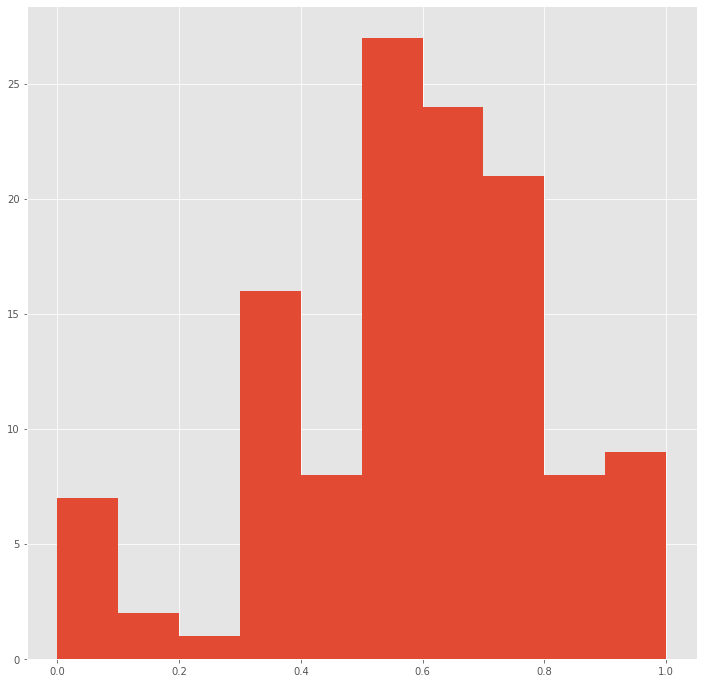

In [168]:
attn_pass_results_df.groupby(['cluster','label'])['correct'].mean().hist(bins=10,figsize=(12,12))

In [158]:
attn_fail_results_df.groupby(['HIT_ID','worker_ID'])['correct'].mean()

HIT_ID                          worker_ID     
301KG0KXAIMFLJEC49AKJ7TUSBZ2HQ  A16S2TL75YHZ79    0.1
                                A1O5EGVKYOSFBA    0.2
3087LXLJ7SHOBDKSUWI6XYO2FZVF0G  A174WAR8BTZPP1    0.5
                                A1IWIGK6CJUU4     0.3
30UZJB2PPNDSQ8Q077NGDKVWTG853N  A3NYIJYBHAJ74V    0.0
                                ANZN7CH92GM4X     0.0
                                AQL7N3YPKDWGW     0.1
329E6HTMT23V8RB3EURMF9EEQ63K3N  A1BQ23IXXOJRRL    0.3
34F34TZU820BCP92S9D5VK995332JV  A22VZZFOP9D3GC    0.1
                                A3AHQB31UANS2Q    0.2
34ZTTGSNK3PWD2GX6K0LFPRX8I6HQE  A1DG4ILSULGPK8    0.6
351S7I5UHFX71BYVESBPN8C7GYMJNV  ARID1N5X77ACN     0.2
36D1BWBEIT21DXFNV6QXBC1Q9XQM2B  ADNPYTX3OVU9V     0.9
379OL9DBTYFC7YP0ZITNFUWBOEF9YJ  A38B2ONJWDQNK2    0.1
38XPGNCKIZ1U6YOJDCACRNH1K5Z4V9  A2ZD812RORX8GU    0.2
3909MD9T35IN23ZM23HLINQ69ZCFE7  A1U3TT3VMH9FU9    0.9
                                AO1I1A8EP7MUQ     0.4
39KMGHJ4S5BXE952REZLUR1Y9WD002  A27